In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist, fashion_mnist, cifar10
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Datasets Used:
- MNIST: Handwritten digits (28×28 grayscale)
- FMNIST: Fashion images (28×28 grayscale)
- CIFAR-10: Object categories (32×32 color)

In [2]:
# Load datasets
(ds1_x, ds1_y), (ts1_x, ts1_y) = mnist.load_data()
(ds2_x, ds2_y), (ts2_x, ts2_y) = fashion_mnist.load_data()
(ds3_x, ds3_y), (ts3_x, ts3_y) = cifar10.load_data()

# Normalize and reshape
def prep(x, col=False):
    x = x.astype("float32") / 255.0
    return np.expand_dims(x, -1) if not col else x

def resize_x(x, size=(71, 71)):
    return tf.image.resize(x, size).numpy()

ds1_x, ts1_x = prep(ds1_x), prep(ts1_x)
ds2_x, ts2_x = prep(ds2_x), prep(ts2_x)
ds3_x, ts3_x = prep(ds3_x, True), prep(ts3_x, True)


In [3]:
def lenet(input_shape, n_cls):
    m = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(6, 5, activation='relu'),
        layers.AvgPool2D(pool_size=(2, 2)),
        layers.Conv2D(16, 5, activation='relu'),
        layers.AvgPool2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(120, activation='relu'),
        layers.Dense(84, activation='relu'),
        layers.Dense(n_cls, activation='softmax')
    ])
    return m


In [4]:
def alexnet(input_shape, n_cls):
    m = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(256, 3, activation='relu', padding='same'),
        layers.Conv2D(256, 3, activation='relu', padding='same'),
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=2),
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(n_cls, activation='softmax')
    ])
    return m


In [5]:
def vgg(input_shape, n_cls):
    m = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(n_cls, activation='softmax')
    ])
    return m


In [6]:
def resnet(input_shape, n_cls):
    i = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 3, padding='same')(i)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Stack 3 residual blocks
    for _ in range(3):
        y = layers.Conv2D(64, 3, padding='same')(x)
        y = layers.BatchNormalization()(y)
        y = layers.ReLU()(y)
        y = layers.Conv2D(64, 3, padding='same')(y)
        y = layers.BatchNormalization()(y)
        x = layers.add([x, y])
        x = layers.ReLU()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(n_cls, activation='softmax')(x)
    return models.Model(i, x)


In [7]:
def inception_module(x, f1, f3r, f3, f5r, f5, pool):
    p1 = layers.Conv2D(f1, 1, activation='relu', padding='same')(x)
    p2 = layers.Conv2D(f3r, 1, activation='relu', padding='same')(x)
    p2 = layers.Conv2D(f3, 3, activation='relu', padding='same')(p2)
    p3 = layers.Conv2D(f5r, 1, activation='relu', padding='same')(x)
    p3 = layers.Conv2D(f5, 5, activation='relu', padding='same')(p3)
    p4 = layers.MaxPooling2D(3, strides=1, padding='same')(x)
    p4 = layers.Conv2D(pool, 1, activation='relu', padding='same')(p4)
    return layers.concatenate([p1, p2, p3, p4], axis=-1)

def googlenet(input_shape, n_cls):
    i = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(i)
    x = layers.MaxPooling2D(3, strides=2)(x)
    x = layers.Conv2D(64, 1, activation='relu')(x)
    x = layers.Conv2D(192, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(3, strides=2)(x)
    x = inception_module(x, 64, 96, 128, 16, 32, 32)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(n_cls, activation='softmax')(x)
    return models.Model(i, x)


In [8]:
def xception(input_shape, n_cls):
    base = tf.keras.applications.Xception(include_top=False, input_shape=input_shape, weights=None)
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(n_cls, activation='softmax')(x)
    return models.Model(base.input, x)

def senet(input_shape, n_cls):
    i = layers.Input(shape=input_shape)
    
    # More conv layers for better feature extraction
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(i)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    # Squeeze-and-Excitation block
    se = layers.GlobalAveragePooling2D()(x)
    se = layers.Reshape((1,1,64))(se)
    se = layers.Dense(16, activation='relu')(se)
    se = layers.Dense(64, activation='sigmoid')(se)
    x = layers.multiply([x, se])

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(n_cls, activation='softmax')(x)
    return models.Model(i, x)



In [9]:
# Evaluation and plotting utilities
metrics_results = []
all_histories = []

def train_eval(m, x, y, vx, vy, ep=3):
    m.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    h = m.fit(x, y, epochs=ep, validation_data=(vx, vy), verbose=0)
    return h

# Function to evaluate model and extract classification metrics
def eval_metrics(model, x_test, y_test, model_name, dataset_name):
    y_pred = np.argmax(model.predict(x_test), axis=1)
    y_true = y_test.flatten() if len(y_test.shape) > 1 else y_test
    # Classification report as a dictionary
    report = classification_report(y_true, y_pred, output_dict=True)
    # Extract macro-averaged metrics
    acc = report['accuracy']
    prec = report['macro avg']['precision']
    rec = report['macro avg']['recall']
    f1 = report['macro avg']['f1-score']
    
    metrics_results.append({
        'Model': model_name,
        'Dataset': dataset_name,
        'Accuracy': round(acc, 4),
        'Precision': round(prec, 4),
        'Recall': round(rec, 4),
        'F1-Score': round(f1, 4)
    })

In [10]:
# Plotting function for training curves (loss and accuracy)
def plot_training_curves(history, model_name, dataset_name):
    plt.figure(figsize=(10, 4))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"{model_name} on {dataset_name} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f"{model_name} on {dataset_name} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [11]:
def plot_comparative_loss_curves(all_histories, dataset_name):
    plt.figure(figsize=(10, 6))
    for model_name, dname, hist in all_histories:
        if dname == dataset_name:
            plt.plot(hist.history['val_loss'], label=model_name)
    plt.title(f"Comparative Validation Loss on {dataset_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

LeNet on MNIST: 0.9869
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step


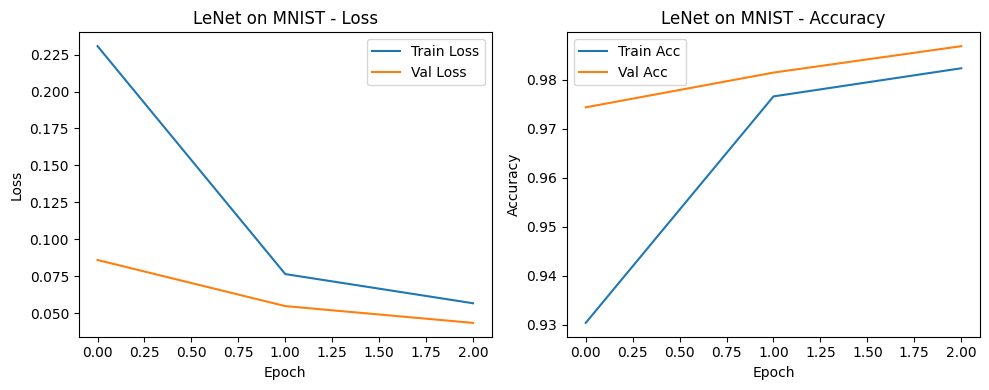

LeNet on FMNIST: 0.8738
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step


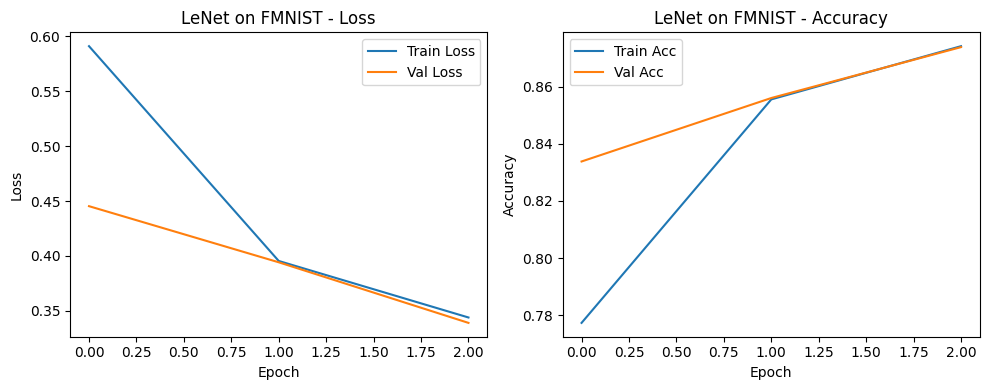

LeNet on CIFAR10: 0.5483
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


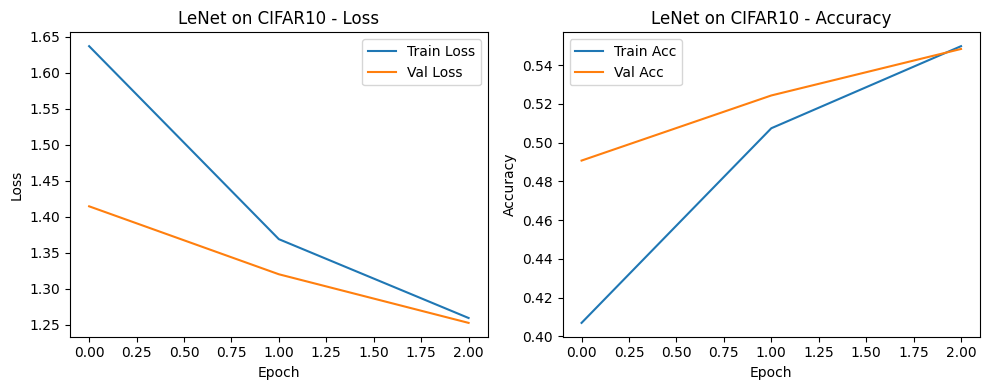

AlexNet on MNIST: 0.9837
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


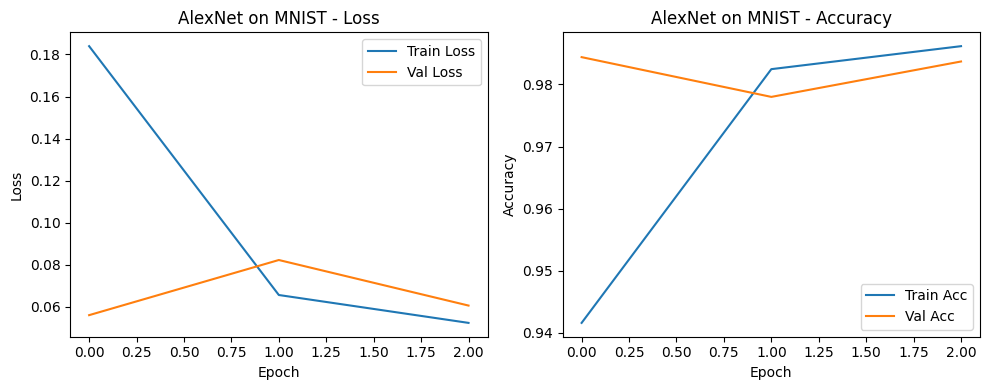

AlexNet on FMNIST: 0.9006
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


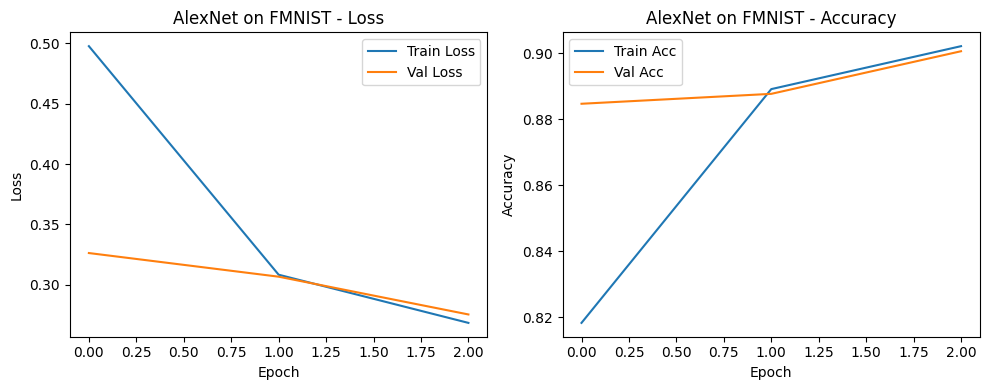

AlexNet on CIFAR10: 0.6333
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


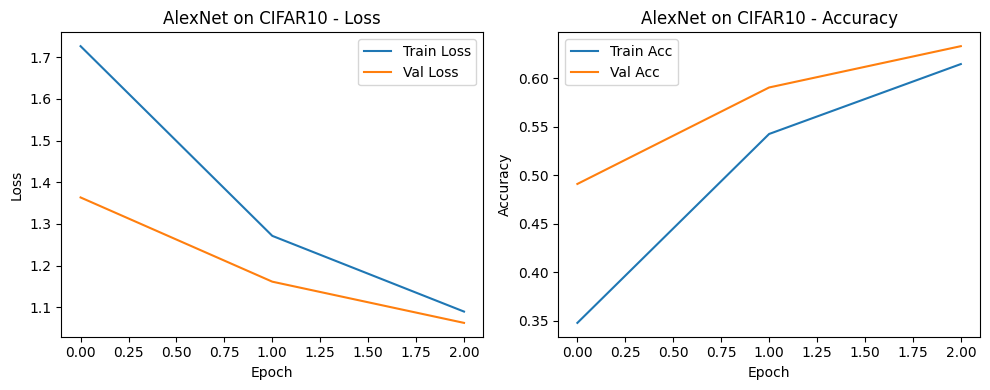

VGG on MNIST: 0.9906
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


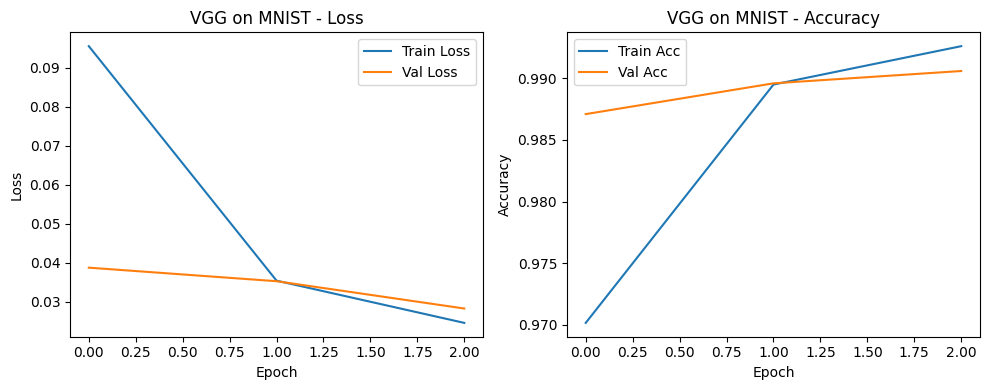

VGG on FMNIST: 0.9091
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


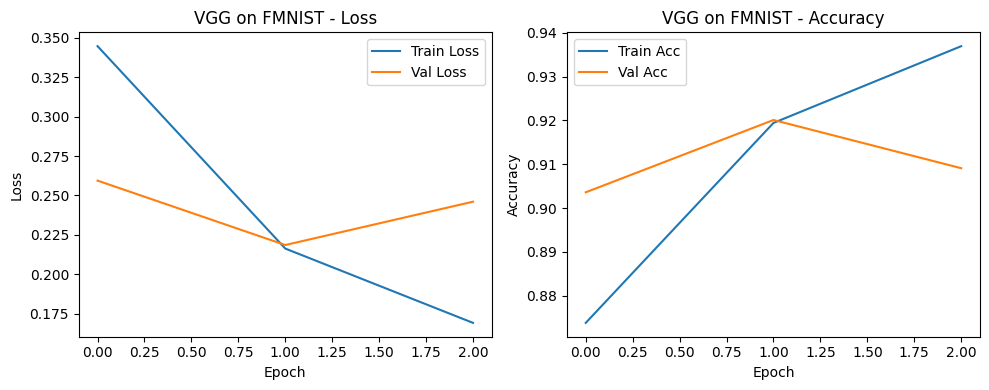

VGG on CIFAR10: 0.7463
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


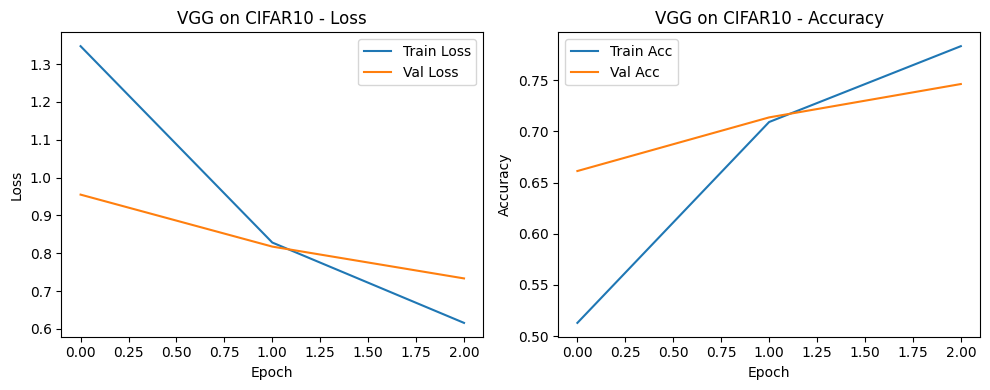

ResNet on MNIST: 0.9504
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step


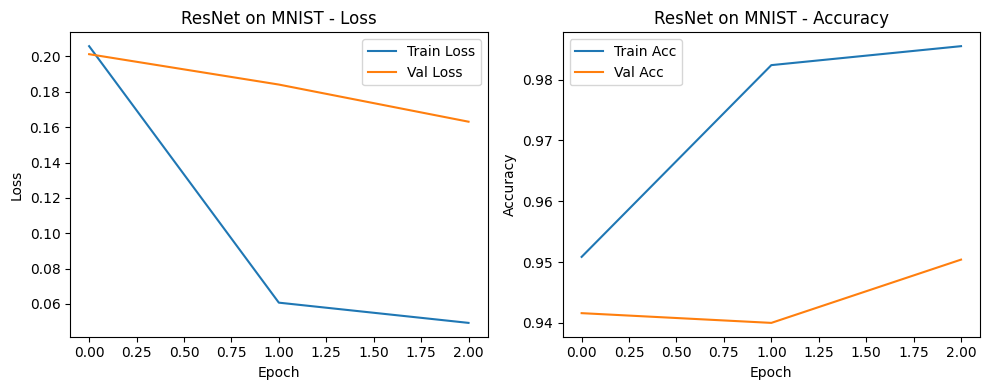

ResNet on FMNIST: 0.8188
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step


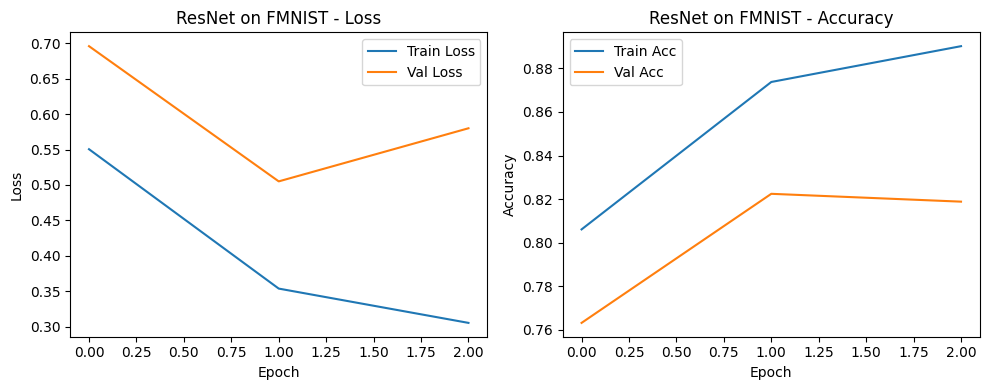

ResNet on CIFAR10: 0.6152
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step


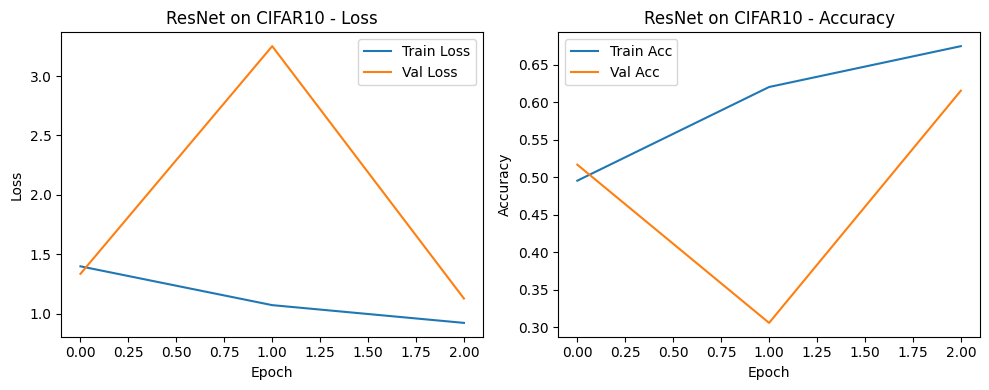

GoogLeNet on MNIST: 0.9855
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


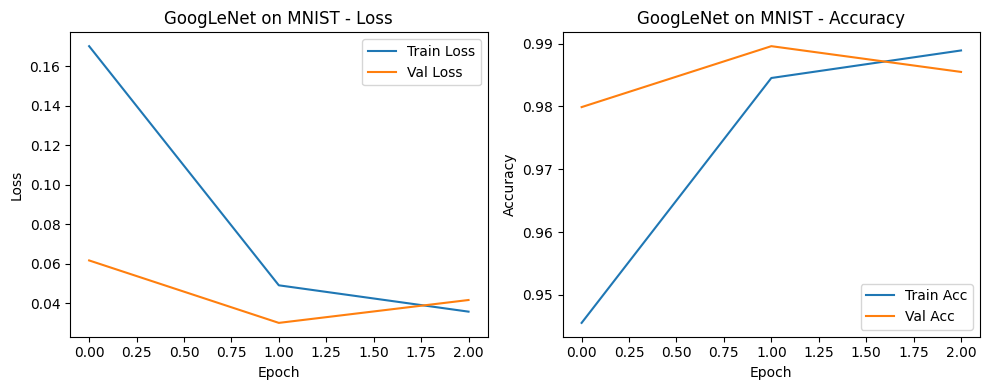

GoogLeNet on FMNIST: 0.8883
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


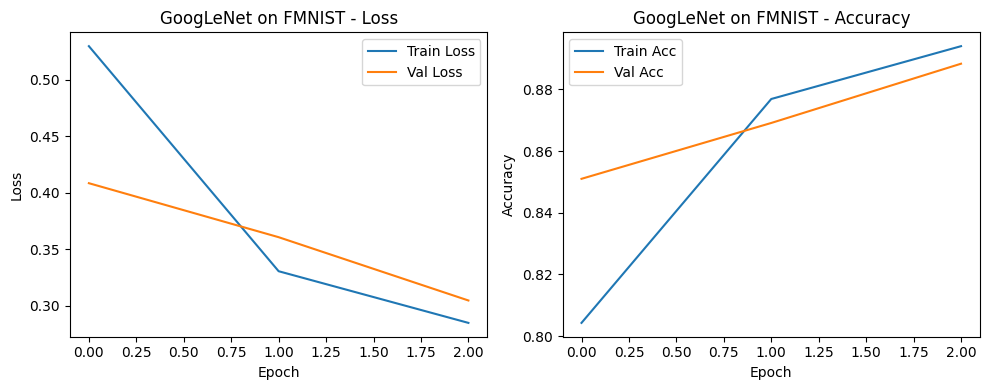

GoogLeNet on CIFAR10: 0.6258
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


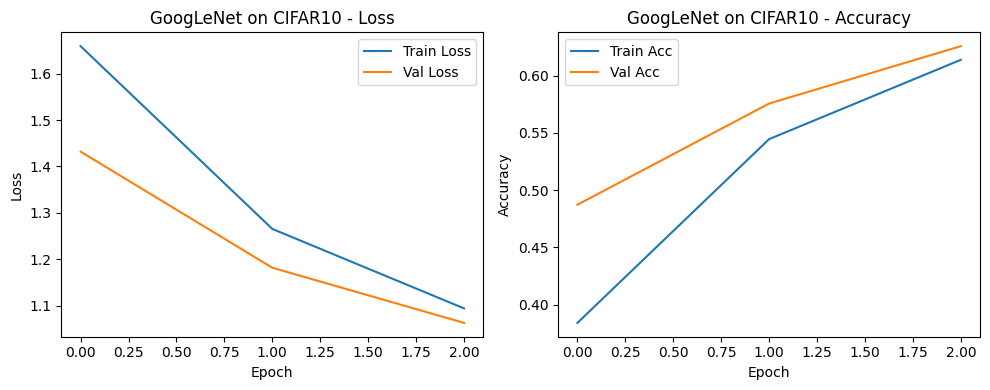

Xception on MNIST: 0.9833
313/313 ━━━━━━━━━━━━━━━━━━━━ 62s 194ms/step


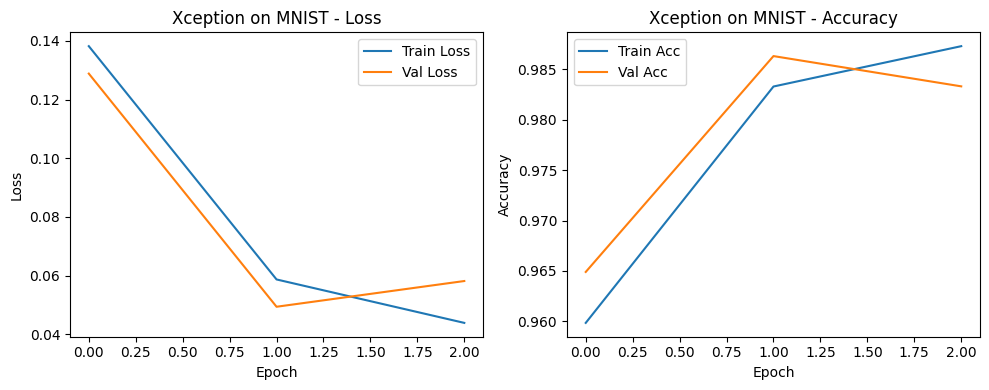

Xception on FMNIST: 0.8992
313/313 ━━━━━━━━━━━━━━━━━━━━ 66s 205ms/step


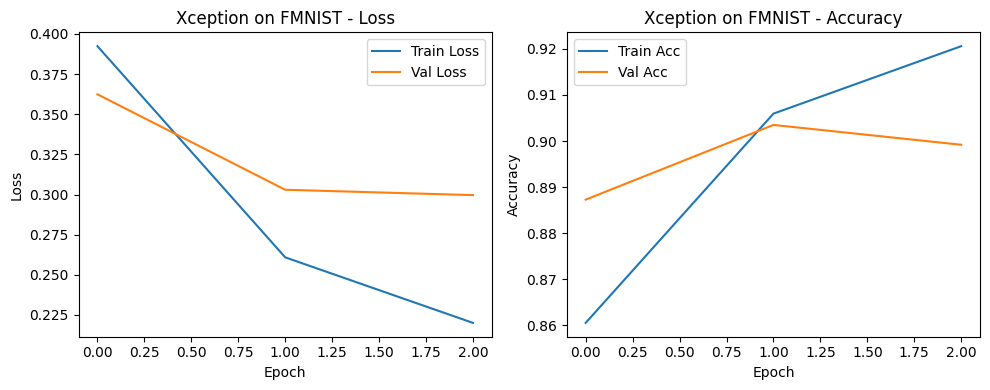

Xception on CIFAR10: 0.7573
313/313 ━━━━━━━━━━━━━━━━━━━━ 66s 205ms/step


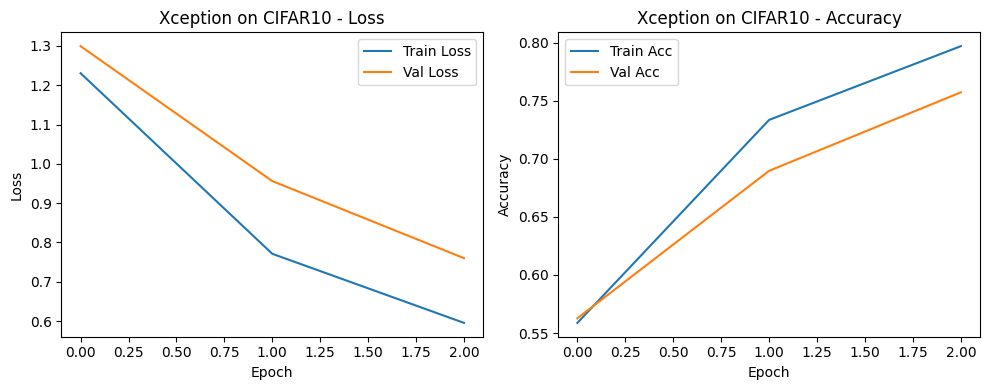

SENet on MNIST: 0.9208
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


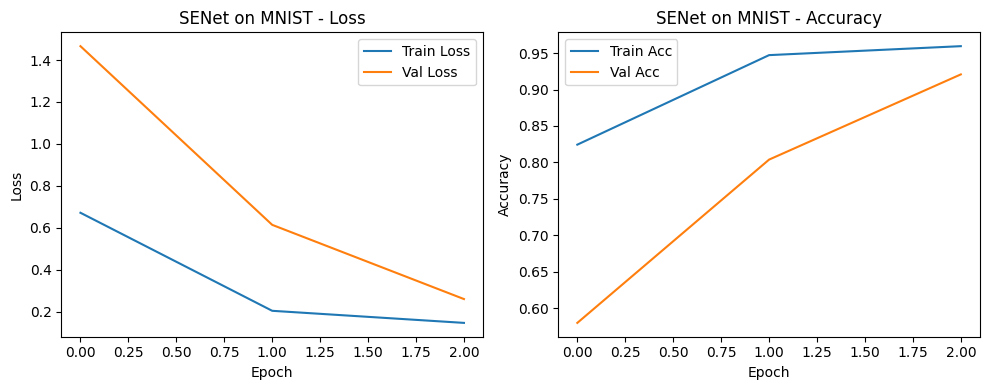

SENet on FMNIST: 0.8186
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


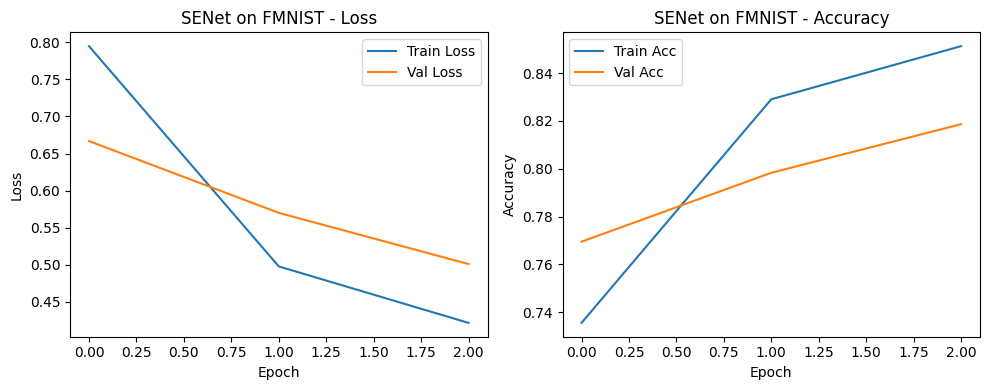

SENet on CIFAR10: 0.5152
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


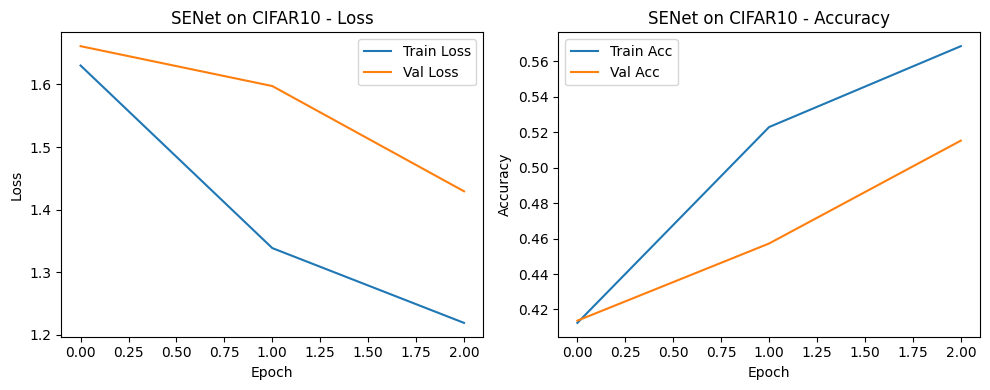

In [12]:
# List of datasets (data, labels, input shape, num_classes, name)
datasets = [
    (ds1_x, ds1_y, ts1_x, ts1_y, (28,28,1), 10, 'MNIST'),
    (ds2_x, ds2_y, ts2_x, ts2_y, (28,28,1), 10, 'FMNIST'),
    (ds3_x, ds3_y, ts3_x, ts3_y, (32,32,3), 10, 'CIFAR10')
]

# List of model functions and names
models_fn = [lenet, alexnet, vgg, resnet, googlenet, xception, senet]
model_names = ['LeNet', 'AlexNet', 'VGG', 'ResNet', 'GoogLeNet', 'Xception', 'SENet']



# Training loop: each model on each dataset
results = []

for mf, mname in zip(models_fn, model_names):
    for x, y, vx, vy, shape, ncls, dname in datasets:
        try:
            # Save original inputs and shape
            x_orig = x.copy()
            vx_orig = vx.copy()
            shape_orig = shape

            # Resize only for Xception
            if mname == "Xception":
                x = resize_x(x)
                vx = resize_x(vx)
                shape = (71, 71, shape[2])  # Resize input shape for Xception

            # Build and train the model
            m = mf(shape, ncls)
            h = train_eval(m, x, y, vx, vy, ep=3)

            # Store final validation accuracy
            acc = h.history['val_accuracy'][-1]
            results.append((mname, dname, acc))
            print(f"{mname} on {dname}: {acc:.4f}")

            eval_metrics(m, vx, vy, mname, dname)
            plot_training_curves(h, mname, dname)
            all_histories.append((mname, dname, h))

            # Restore original data and shape
            x = x_orig
            vx = vx_orig
            shape = shape_orig

        except Exception as e:
            results.append((mname, dname, str(e)))
            print(f"Error: {mname} on {dname} -> {e}")


In [13]:
# Save results
df_res = pd.DataFrame(results, columns=['Model', 'Dataset', 'Val Accuracy'])
print("\nValidation Accuracy Summary:\n", df_res)
df_res.to_csv("cnn_validation_accuracy.csv", index=False)


Validation Accuracy Summary:
         Model  Dataset  Val Accuracy
0       LeNet    MNIST        0.9869
1       LeNet   FMNIST        0.8738
2       LeNet  CIFAR10        0.5483
3     AlexNet    MNIST        0.9837
4     AlexNet   FMNIST        0.9006
5     AlexNet  CIFAR10        0.6333
6         VGG    MNIST        0.9906
7         VGG   FMNIST        0.9091
8         VGG  CIFAR10        0.7463
9      ResNet    MNIST        0.9504
10     ResNet   FMNIST        0.8188
11     ResNet  CIFAR10        0.6152
12  GoogLeNet    MNIST        0.9855
13  GoogLeNet   FMNIST        0.8883
14  GoogLeNet  CIFAR10        0.6258
15   Xception    MNIST        0.9833
16   Xception   FMNIST        0.8992
17   Xception  CIFAR10        0.7573
18      SENet    MNIST        0.9208
19      SENet   FMNIST        0.8186
20      SENet  CIFAR10        0.5152


In [14]:
df_metrics = pd.DataFrame(metrics_results)
print("\nEvaluation Metrics Summary:\n", df_metrics)
df_metrics.to_csv("cnn_evaluation_metrics.csv", index=False)


Evaluation Metrics Summary:
         Model  Dataset  Accuracy  Precision  Recall  F1-Score
0       LeNet    MNIST    0.9869     0.9867  0.9868    0.9868
1       LeNet   FMNIST    0.8738     0.8751  0.8738    0.8736
2       LeNet  CIFAR10    0.5483     0.5446  0.5483    0.5411
3     AlexNet    MNIST    0.9837     0.9837  0.9835    0.9834
4     AlexNet   FMNIST    0.9006     0.9030  0.9006    0.9011
5     AlexNet  CIFAR10    0.6333     0.6320  0.6333    0.6232
6         VGG    MNIST    0.9906     0.9907  0.9904    0.9905
7         VGG   FMNIST    0.9091     0.9124  0.9091    0.9078
8         VGG  CIFAR10    0.7463     0.7544  0.7463    0.7479
9      ResNet    MNIST    0.9504     0.9537  0.9501    0.9497
10     ResNet   FMNIST    0.8188     0.8442  0.8188    0.8046
11     ResNet  CIFAR10    0.6152     0.6819  0.6152    0.5935
12  GoogLeNet    MNIST    0.9855     0.9855  0.9858    0.9856
13  GoogLeNet   FMNIST    0.8883     0.8874  0.8883    0.8870
14  GoogLeNet  CIFAR10    0.6258     0.6

MNIST (Handwritten Digits - Simple grayscale)
    VGG	0.9906 
    All models perform extremely well (> 98%), except SENet and ResNet.
    This is expected because MNIST is a simple dataset, and even lightweight models can achieve near-perfect results.
FMNIST (Fashion - Grayscale but more complex than MNIST)
    VGG	0.9091
    VGG, AlexNet, and Xception lead here. This dataset benefits from deeper architectures.
    ResNet and SENet underperform a bit — possibly due to under-tuning or fewer residual layer
CIFAR-10 (Colored, complex, 32×32 RGB)
    Xception	0.7573
    Xception and VGG perform best — thanks to their ability to learn deep features and handle colored images.
    LeNet and SENet struggle here due to architecture simplicity and/or channel handling.


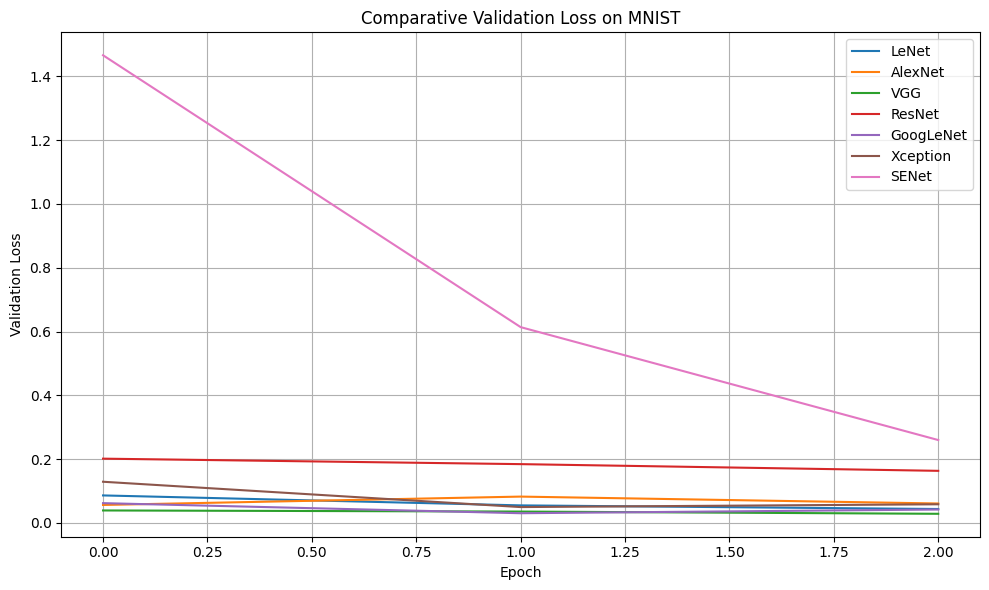

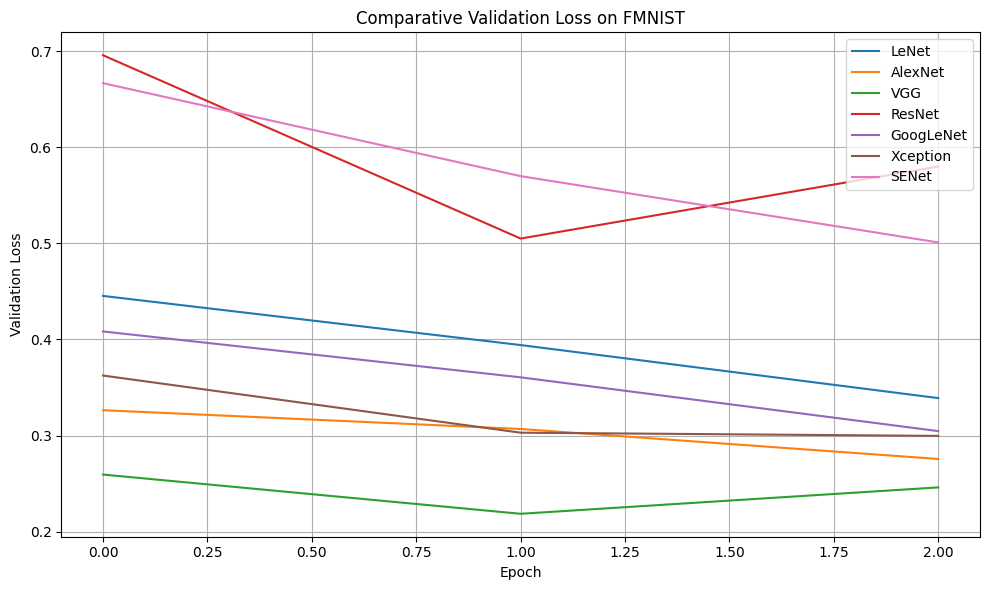

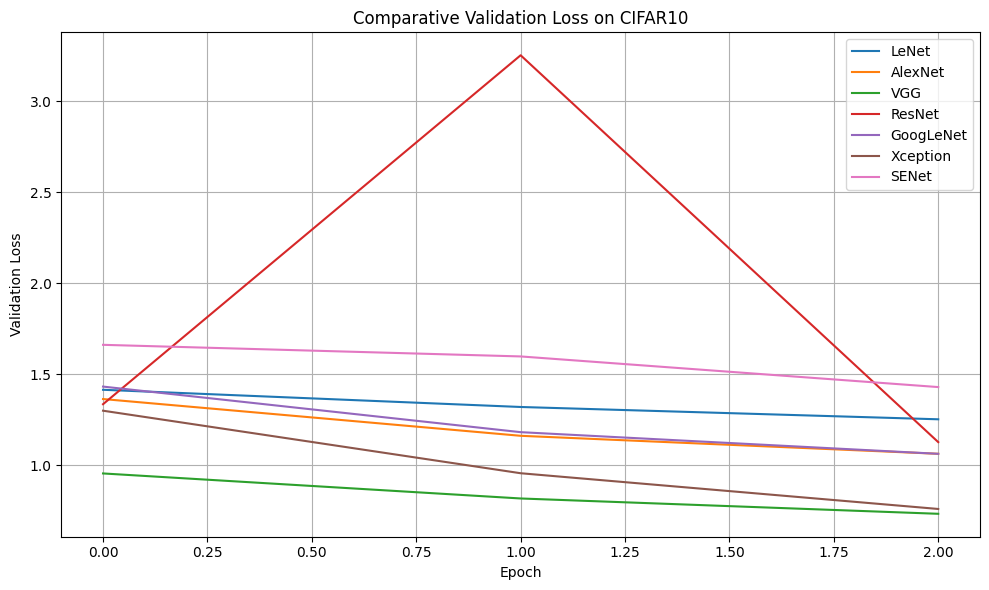

In [15]:
# Plot comparative loss curves
datasets_names = ['MNIST', 'FMNIST', 'CIFAR10']
for ds_name in datasets_names:
    plot_comparative_loss_curves(all_histories, ds_name)